In [ ]:
!pip install shap
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE" -O train.json && rm -rf /tmp/cookies.txt

import json
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from textblob import TextBlob
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from tqdm.notebook import tqdm
tqdm.pandas()
import pdb

In [79]:
# Sample 1000 data from the training set
with open('train.json') as json_file:
    data = json.load(json_file)
df = pd.DataFrame.from_records(data).sample(n=1000, random_state=0)

# Create features from text and reply
def _preprocess(data):

  # Length
  data['text_word_count'] = len(data['text'].split())

  # Polarity and subjectivity
  textblob = TextBlob(data['text'])
  data['text_pol'] = textblob.sentiment.polarity
  data['text_sub'] = textblob.sentiment.subjectivity

  # POS count
  pos_dict = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
  } 
  def _pos_count(text, type):
    count = 0
    for (word, pos) in TextBlob(text).tags:
      if pos in pos_dict[type]:
        count += 1
    return count
  data['text_adj_count'] = _pos_count(data['text'], 'adj')
  data['reply_adj_count'] = _pos_count(data['reply'], 'adj')
  data['text_adv_count'] = _pos_count(data['text'], 'adv')
  data['reply_adv_count'] = _pos_count(data['reply'], 'adv')

  # [TODO 1] Create at least 5 features. ###########
  # E.g. Length of reply, sentiment polarity, ...
  data['text_verb_count'] = _pos_count(data['text'], 'verb')
  data['reply_verb_count'] = _pos_count(data['reply'], 'verb')
  data['text_pron_count'] = _pos_count(data['text'], 'pron')
  data['reply_pron_count'] = _pos_count(data['reply'], 'pron')
  data['text_noun_count'] = _pos_count(data['text'], 'noun')
  data['reply_noun_count'] = _pos_count(data['reply'], 'noun')




  ##################################################

  data['label'] = 1 if data['label']=='real' else 0
  return data

df = df.progress_apply(lambda x: _preprocess(x), axis=1)

# Take labels and remove unused columns in data
labels = df['label'].to_numpy()
df = df.drop(columns=['idx', 'text', 'categories', 'context_idx', 'reply', 'mp4', 'label'])

# Split the dataset for training and validation
X_train,X_test,Y_train,Y_test = train_test_split(*(df, labels), test_size=0.2, random_state=0)

# Model Leanring

## For SVM 

In [80]:
# Train a SVM classifier
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)
print(f"SVC Test Accuracy: {accuracy_score(Y_test, svm.predict(X_test))}")
print(f"SVC Test Loss: {log_loss(Y_test, svm.predict_proba(X_test))}")

SVC Test Accuracy: 0.94
SVC Test Loss: 0.15442568262687148


## For Random Forest

In [81]:
# Train a Random Forest classifier
rfc = sklearn.ensemble.RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, Y_train)
print(f"Random Forest Test Accuracy: {accuracy_score(Y_test, rfc.predict(X_test))}")
print(f"Random Forest Test Loss: {log_loss(Y_test, rfc.predict_proba(X_test))}")

Random Forest Test Accuracy: 0.975
Random Forest Test Loss: 0.17341577081878978


## For XGBoost

In [82]:
import xgboost

# Train a XGBoost classifier
xgb = xgboost.XGBClassifier(objective='binary:logistic', n_estimators=2)
xgb.fit(X_train, Y_train)
print(f"XGB Test Accuracy: {accuracy_score(Y_test, xgb.predict(X_test))}")
print(f"XGB Test Loss: {log_loss(Y_test, xgb.predict_proba(X_test))}")

XGB Test Accuracy: 0.985
XGB Test Loss: 0.5405008620023728


# Explaination

## For SVC

In [83]:
##### For SVC #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, shap.kmeans(X_train, 100)) # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)

In [84]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

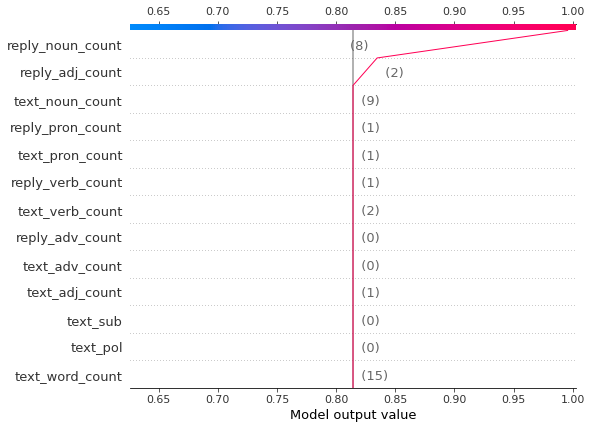

In [85]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

## For Random Forest

In [86]:
##### For RFC #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(rfc.predict_proba, shap.kmeans(X_train, 100)) # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)


In [87]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:]) #, link="logit")

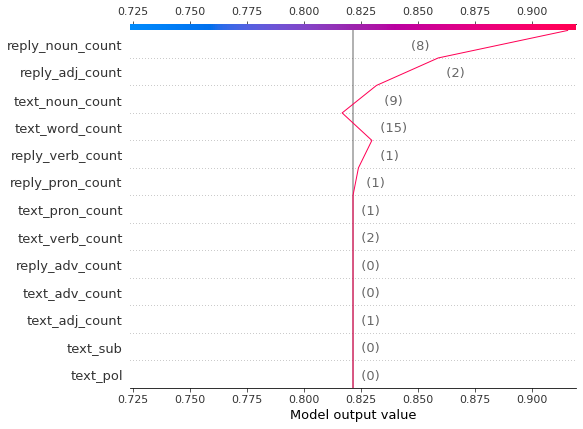

In [88]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

## For XGBoost

In [89]:
##### For XGBootst #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(lambda x: xgb.predict_proba(x, validate_features=False), shap.kmeans(X_train, 100))  # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)

In [90]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

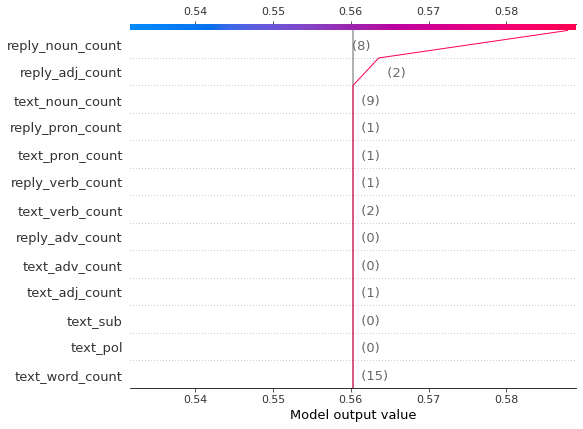

In [91]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

In [92]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# [TODO 2] Discussion

1. Compare the importance of different features. Are the results similar among different models? Please address what you find below.

No, in Random Forest, it can find more useful feature such as "text_word_count".

2. What’ll happen if we remove useless features according to the explanation results? Please do a simple experiment and address what you find.

We remove "text_adj_count", in SVC and XGBoost, other features still maintain same contribution with having "text_adj_count", in Random Forest, "text_noun_count" have more contribution then having "text_adj_count".

3. Without any constraint, please share one additional observation you find.

"reply_noun_count" is an important feature, if we remove it, in Random Forest, the "text_sub" contribution is higher then when "reply_noun_count" exist, so these two features might have relative.  And after adding more features, the accuracy of three method is higher.